# Load and Prepare Data

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from rich import print as printr
import numpy as np
from pathlib import Path
from instance_dac.utils.data_loading import load_performance_data, load_eval_data

# LEVELS OF AGGREGATION
# 1. eval episode
# 1.1 selector runs
# 2. seed
# 3. instance

path = "../runs/Sigmoid"
agent_name = "ppo"
train_instance_set = "2D3M_train"
train_instance_set_id = "sigmoid_2D3M_train"
test_instance_set = "2D3M_test"
test_instance_set_id = "sigmoid_2D3M_test"
benchmark_id = "Sigmoid"

path = "../runs/CMA-ES"
agent_name = "ppo_sb3"
train_instance_set = "seplow_train"
test_instance_set_id = "test"
train_instance_set_id = "train"
test_instance_set = "seplow_test"
benchmark_id = "CMA-ES"

aggregate_selector_runs = True
normalize_performance_per_instance = True
remove_oracle = True

path = Path(path) / train_instance_set / agent_name
# data = load_eval_data(path=path, instance_set_id=test_instance_set_id, instance_set=test_instance_set)

data = pd.read_csv(f"eval_data_{test_instance_set_id}.csv")

if remove_oracle:
    data = data.drop(np.where(data["origin"] == "oracle")[0])

# Rename selector
ids = data["origin"] == "selector"
data["origin"][ids] = data["instance_set_id"][ids].apply(lambda x: f"selector_{x}")

# Normalize performance per instance
if normalize_performance_per_instance:
    D = []
    for gid, gdf in data.groupby("instance"):
        Gmax = gdf["overall_performance"].max()
        Gmin = gdf["overall_performance"].min()
        gdf["overall_performance"] = (gdf["overall_performance"] - Gmin) / (Gmax - Gmin)
        D.append(gdf)
    data = pd.concat(D).reset_index(drop=True)

# Prepare selector data to aggregate across runs and seeds
ids = data["origin"].str.startswith("selector")
if aggregate_selector_runs:
    data.loc[ids, "origin"] = data["instance_set_id"][ids].apply(lambda x: "selector__" + "__".join(x.split("__")[:-2]))
else:
    data.loc[ids, "origin"] = data["instance_set_id"][ids].apply(lambda x: "selector__" + "__".join(x.split("__")[:-2]) + f"__{x.split('__')[-1]}")


/tmp/ipykernel_88070/2908006821.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["origin"][ids] = data["instance_set_id"][ids].apply(lambda x: f"selector_{x}")


# fANOVA

/tmp/ipykernel_88070/3747947388.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "method"] = df["instance_set_id"].apply(lambda x: x.split("__")[2])
/tmp/ipykernel_88070/3747947388.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "feature_type"] = df["instance_set_id"].apply(lambda x: x.split("__")[3])
/tmp/ipykernel_88070/3747947388.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

{'feature_type': ['Catch22'], 'method': ['MIS', 'DS'], 'source_features': ['A', 'RA', 'R']}

/tmp/ipykernel_88070/3747947388.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k] = df[k].apply(lambda x: v.index(x))


[
    feature_type, Type: Categorical, Choices: {0}, Default: 0,
    method, Type: Categorical, Choices: {0, 1}, Default: 0,
    source_features, Type: Categorical, Choices: {0, 1, 2}, Default: 0,
    threshold, Type: Ordinal, Sequence: {0.7, 0.8, 0.9, 0.95}, Default: 0.7
]

(9.354007219329379e-05, 0.0, 0.0, 0.0, 6.97988198336185e-05, 6.774454255542308e-05, 0.000159390840203375, 0.00020222314415176655, 0.0, 5.730408454530589e-05, 0.00013428349373449514, 0.00016139542383462624, 0.0001722056871593766, 0.00015598592600402593, 4.91301020711569e-05, 0.00014000154170891783, 0.00014464459373332835, 0.00017647866292143803, 0.00015005816667995346, 0.00015005155986920897, 0.0001565838040344167, 0.0001688291820611731, 8.944231944689898e-05, 0.0001895721936124481, 0.0001681361444422004, 0.00014341350114225668, 0.00013577825130262243, 0.00013166133410583432, 7.621263756764186e-17, 0.00018065568837684042, 0.00018468950730769486, 0.00016674352015640594)
{}
(1,) {'individual importance': 0.7143254904650082, 'total importance': 0.7143254904650082, 'individual std': 0.27476534904077443, 'total std': 0.27476534904077443}
(1, 2) {'individual importance': 0.2134675002327154, 'total importance': 0.9642857142857123, 'individual std': 0.23514023275040866, 'total std': 0.185576872

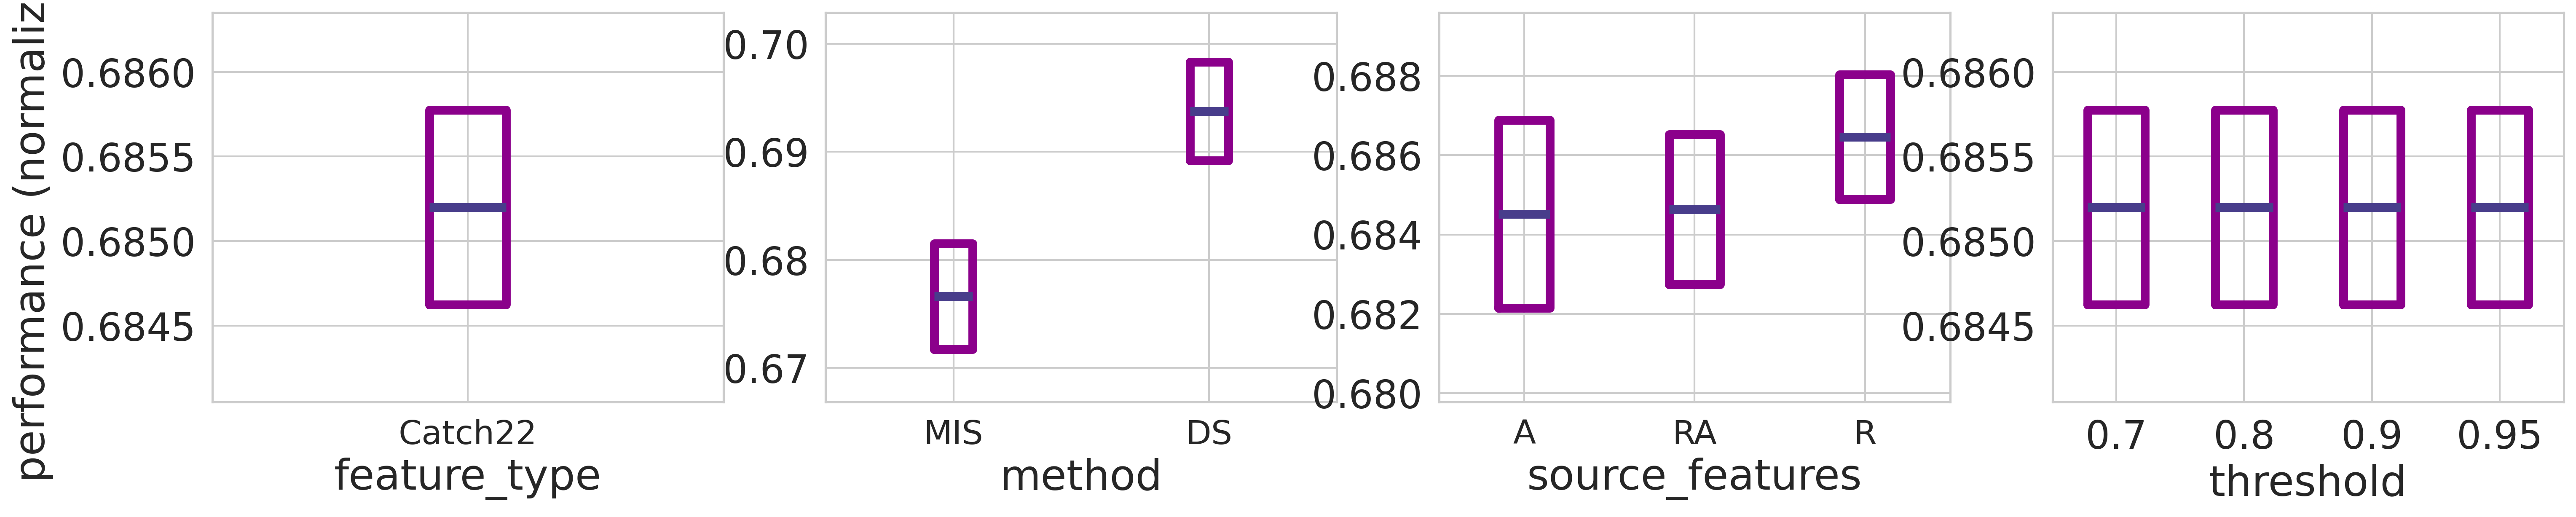

In [18]:
import fanova
import fanova.visualizer
from ConfigSpace import ConfigurationSpace, Categorical, OrdinalHyperparameter

import itertools as it
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from ConfigSpace.hyperparameters import Hyperparameter, CategoricalHyperparameter, Constant, OrdinalHyperparameter, \
    NumericalHyperparameter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


import seaborn as sns

sns.set_palette("colorblind")
sns.set(font_scale=2)
sns.set_style("white")


df = data[data["origin"].str.startswith("selector")]
df.loc[:, "method"] = df["instance_set_id"].apply(lambda x: x.split("__")[2])
df.loc[:, "feature_type"] = df["instance_set_id"].apply(lambda x: x.split("__")[3])
df.loc[:, "source_features"] = df["instance_set_id"].apply(lambda x: x.split("__")[4])
df.loc[:, "threshold"] = df["instance_set_id"].apply(lambda x: float(x.split("__")[5]))

cols = ["method", "feature_type", "source_features", "threshold"]
cols.sort()
cat_features = ["method", "feature_type", "source_features"]
cat_features.sort()

cat_map = {k: list(df[k].unique()) for k in cat_features}
printr(cat_map)
for k, v in cat_map.items():
    df[k] = df[k].apply(lambda x: v.index(x))


sequence = list(df["threshold"].unique())
sequence.sort()
config_space = ConfigurationSpace()
hps = [
    Categorical(name="method", items=df["method"].unique()),
    Categorical(name="feature_type", items=df["feature_type"].unique()),
    Categorical(name="source_features", items=df["source_features"].unique()),
    OrdinalHyperparameter(name="threshold", sequence=sequence),
    
]
config_space.add_hyperparameters(hps)



printr(config_space.get_hyperparameters())

X = df.loc[:, cols]
y = df.loc[:, "overall_performance"].to_numpy()

f = fanova.fANOVA(X, y, config_space = config_space, n_trees=32, bootstrapping=True)

print(f.trees_total_variance)
print(f.V_U_individual)

dims = (0,1,2,3)  # idx of configspace HPs
vlines = [
    [0.05, 0.1, 0.5, 1],
    [0, 1, 2],
    [0.05, 0.1, 0.25, 1],
]

importance_dict = f.quantify_importance(dims)  

for k in sorted(list(importance_dict.keys()), key=lambda t: importance_dict[t]['individual importance'], reverse=True):
    print(k, importance_dict[k])

v = fanova.visualizer.Visualizer(f, f.cs, ".")


def plot_marginal(self, param, resolution=100, log_scale=None, show=True, incumbents=None, ax=None):
    """
    Creates a plot of marginal of a selected parameter

    Parameters
    ----------
    param: int or str
        Index of chosen parameter in the ConfigSpace (starts with 0)
    resolution: int
        Number of samples to generate from the parameter range as values to predict
    log_scale: boolean
        If log scale is required or not. If no value is given, it is deduced from the ConfigSpace provided
    show: boolean
        whether to call plt.show() to show plot directly as interactive matplotlib-plot
    incumbents: List[Configuration]
        list of ConfigSpace.Configurations that are marked as incumbents
    """
    param, param_name, param_idx = self._get_parameter(param)
    print(param, self._get_parameter(param))

    # check if categorical
    if isinstance(param, NumericalHyperparameter):
        # PREPROCESS
        mean, std, grid = self.generate_marginal(param_idx, resolution)
        mean = np.asarray(mean)
        std = np.asarray(std)

        lower_curve = mean - std
        upper_curve = mean + std

        if log_scale is None:
            log_scale = param.log or (np.diff(grid).std() > 0.000001)

        # PLOT
        if log_scale:
            if np.diff(grid).std() > 0.000001:
                self.logger.info("It might be better to plot this parameter '%s' in log-scale.", param_name)
            plt.semilogx(grid, mean, 'b', label='predicted %s' % self._y_label)
        else:
            plt.plot(grid, mean, 'b', label='predicted %s' % self._y_label)
        plt.fill_between(grid, upper_curve, lower_curve, facecolor='red', alpha=0.6, label='std')

        if incumbents is not None:
            if not isinstance(incumbents, list):
                incumbents = [incumbents]
            values = [inc[param_name] for inc in incumbents if param_name in inc and inc[param_name] is not None]
            indices = [(np.abs(np.asarray(grid) - val)).argmin() for val in values]
            if len(indices) > 0:
                plt.scatter(list([grid[idx] for idx in indices]),
                            list([mean[idx] for idx in indices]),
                            label='incumbent', c='black', marker='.', zorder=999)

        plt.xlabel(param_name)
        plt.ylabel(self._y_label)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

    else:
        # PREPROCESS
        if isinstance(param, CategoricalHyperparameter):
            labels = param.choices
            categorical_size = len(param.choices)
        elif isinstance(param, OrdinalHyperparameter):
            labels = param.sequence
            categorical_size = len(param.sequence)
        elif isinstance(param, Constant):
            labels = str(param)
            categorical_size = 1
        else:
            raise ValueError("Parameter %s of type %s not supported." % (param.name, type(param)))

        indices = np.arange(1, categorical_size + 1, 1)
        mean, std = self.generate_marginal(param_idx)
        min_y = mean[0]
        max_y = mean[0]

        # PLOT
        if ax is None:
            ax = plt.gca()
        b = ax.boxplot(
            [[x] for x in mean], 
            patch_artist=False, 
            showmeans=False, 
            showfliers=False,
            medianprops={
                "color": "darkslateblue", 
                "linewidth": 5
            },
            boxprops={
                # "facecolor": "C0", 
                # "edgecolor": "white",
                "color": "darkmagenta",
                "linewidth": 5,
            },
            # whiskerprops={"color": "C0", "linewidth": 1.5},
            # capprops={"color": "C0", "linewidth": 1.5}
        )
        ax.set_xticks(indices, labels)

        # blow up boxes
        for box, std_ in zip(b["boxes"], std):
            y = box.get_ydata()
            y[2:4] = y[2:4] + std_
            y[0:2] = y[0:2] - std_
            y[4] = y[4] - std_
            box.set_ydata(y)
            min_y = min(min_y, y[0] - std_)
            max_y = max(max_y, y[2] + std_)

        ax.set_ylim([min_y, max_y])

        # _bp = plt.boxplot([[x] for x in mean], patch_artist=True)
        # for median in _bp['medians']: median.set(color ='forestgreen', linewidth = 3, alpha=0.4) 
        # for cap in _bp['caps']: cap.set(color ='#8B008B', linewidth = 2) 

        ax.set_ylabel(self._y_label)
        ax.set_xlabel(param_name)
    if show:
        plt.show()
    else:
        return ax


sns.set_style("whitegrid")

fig = plt.figure(figsize=(len(dims)*6, 4), dpi=300)
axes = fig.subplots(nrows=1, ncols=len(dims), sharey=False)
for i, dim in enumerate(dims):
    ax = axes[i]
    ax = plot_marginal(v, dim, show=False, ax=ax)
    # ax = plt.gca()
    # x = vlines[dim]
    # ymin, ymax = plt.gca().get_ylim()
    # plt.vlines(x, ymin, ymax)
    print(dim, cols[dim])
    if cols[dim] in cat_features:
        ax.set_xticklabels(cat_map[cols[dim]], fontsize=19)
    # match cols[dim]:
    #     case "method":
    #         ax.set_xticks(np.arange(0, len(cat_map["method"])))  # hack
    #         ax.set_xticklabels(cat_map["method"], fontsize=19)
    #     case "delta":
    #         ax.set_xlabel(r"$\Delta \alpha$")
    #     case "atol_rel":
    #         ax.set_xlabel(r"$\epsilon$")
    ax.set_ylabel(None)
axes[0].set_ylabel("performance (normalized)")
fig.set_tight_layout(False)
fn = Path(f"HP_importance_{benchmark_id}.pdf")
fn.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(fn, bbox_inches="tight", dpi=300)
plt.show()
    
# v.plot_pairwise_marginal([0,1], resolution=50)
# v.create_all_plots()
# v.create_most_important_pairwise_marginal_plots()

# Reset seaborn
sns.set_palette("colorblind")
sns.set(font_scale=1)
sns.set_style("whitegrid")

# Abs Perf / Rliable
## Prepare performance data

In [19]:
# Aggregate across eval episodes
if aggregate_selector_runs:
    D = []
    for gid, gdf in data.groupby(["origin", "seed", "instance", "selector_run"]):
        if gid[0].startswith("selector"):
            D.append(pd.Series({
                "origin": gid[0],
                "seed": gid[1],
                "instance": gid[2],
                "overall_performance": gdf["overall_performance"].mean()
            }))
        else:
            print(gid)
            D.append(gdf)
    perf = pd.concat(D, axis=1).T
    perf = pd.concat([perf, data[~data["origin"].str.startswith("selector")]])
else:
    perf = data

perf = pd.DataFrame(perf.groupby(["origin", "seed", "instance"])["overall_performance"].mean())
perf_dict = {}
for gid, gdf in perf.groupby("origin"):
    gdf = gdf.reset_index()
    P = gdf["overall_performance"].to_numpy()
    P = P.reshape((gdf["seed"].nunique(), gdf["instance"].nunique()))
    perf_dict[gid] = P

## Boxplot Performance (All Variants)

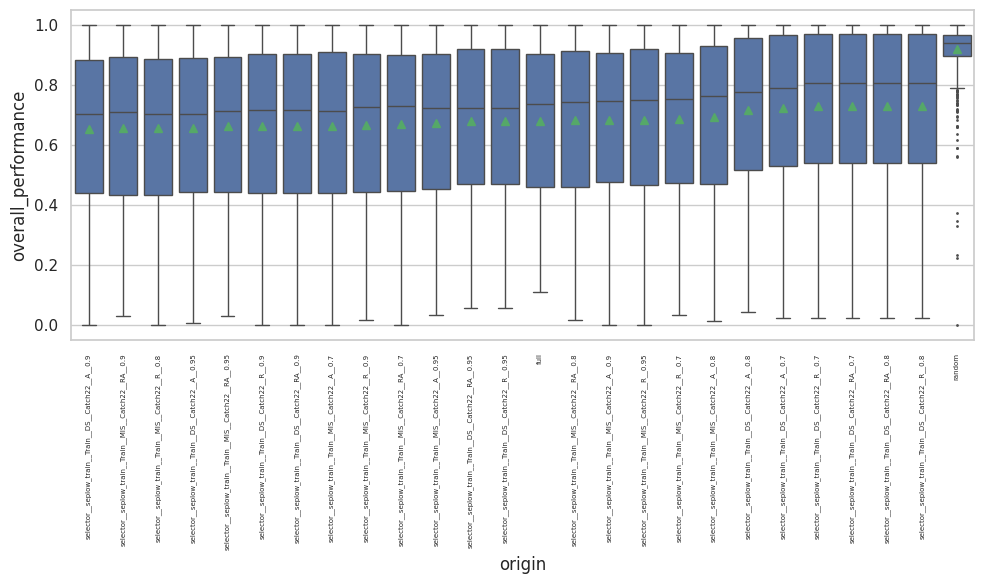

In [20]:
agg_fun = np.mean
sorted_series = data.groupby(["origin"]).apply(lambda x: agg_fun(x["overall_performance"])).sort_values()
sorter = list(sorted_series.index)

df = data.sort_values(by="origin", key=lambda column: column.map(lambda e: sorter.index(e)))


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
df["-overall_performance"] = -df["overall_performance"]
ax = sns.boxplot(data=df, x="origin", y="overall_performance", ax=ax, fliersize=1, showfliers=True, showmeans=True)
ax.tick_params(axis='x', labelrotation=90, labelsize=5)
# ax.set_yscale("log")
fig.set_tight_layout(True)
plt.show()

## Check source of stochasticity

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


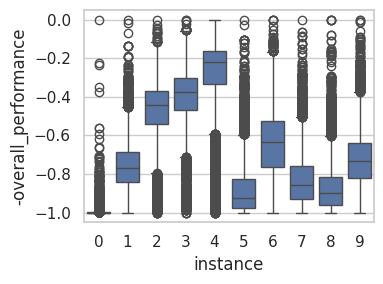

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


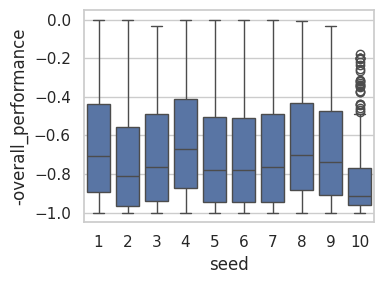

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


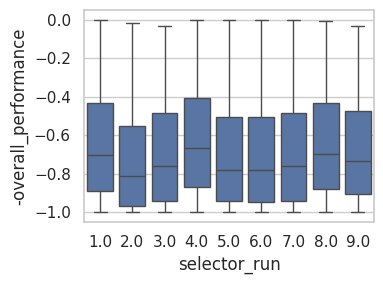

In [29]:

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=df, x="instance", y="-overall_performance", ax=ax)
# ax.tick_params(axis='x', labelrotation=90, labelsize=5)
# ax.set_yscale("log")
fig.set_tight_layout(True)
plt.show()

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=df, x="seed", y="-overall_performance", ax=ax)
# ax.tick_params(axis='x', labelrotation=90, labelsize=5)
# ax.set_yscale("log")
fig.set_tight_layout(True)
plt.show()

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=df, x="selector_run", y="-overall_performance", ax=ax)
# ax.tick_params(axis='x', labelrotation=90, labelsize=5)
# ax.set_yscale("log")
fig.set_tight_layout(True)
plt.show()

## Aggregate Scores with rliable

In [30]:
import pickle
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

metric_names = ['Median', 'IQM', 'Mean']#, 'Optimality Gap']

algorithms = list(perf_dict.keys())
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices, each of which is of size `(num_runs x num_games)`.
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  #metrics.aggregate_optimality_gap(x)
  ])
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  perf_dict, aggregate_func, reps=5000)

with open(f'perf_dict_{benchmark_id}.pickle', 'wb') as handle:
    pickle.dump(perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'aggregate_scores_{benchmark_id}.pickle', 'wb') as handle:
    pickle.dump(aggregate_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'aggregate_score_cis_{benchmark_id}.pickle', 'wb') as handle:
    pickle.dump(aggregate_score_cis, handle, protocol=pickle.HIGHEST_PROTOCOL)


INFO:absl:Calculating estimates for full ...
INFO:absl:Calculating estimates for random ...
INFO:absl:Calculating estimates for selector__seplow_train__Train__DS__Catch22__A__0.7 ...
INFO:absl:Calculating estimates for selector__seplow_train__Train__DS__Catch22__A__0.8 ...
INFO:absl:Calculating estimates for selector__seplow_train__Train__DS__Catch22__A__0.9 ...
INFO:absl:Calculating estimates for selector__seplow_train__Train__DS__Catch22__A__0.95 ...
INFO:absl:Calculating estimates for selector__seplow_train__Train__DS__Catch22__RA__0.7 ...
INFO:absl:Calculating estimates for selector__seplow_train__Train__DS__Catch22__RA__0.8 ...
INFO:absl:Calculating estimates for selector__seplow_train__Train__DS__Catch22__RA__0.9 ...
INFO:absl:Calculating estimates for selector__seplow_train__Train__DS__Catch22__RA__0.95 ...
INFO:absl:Calculating estimates for selector__seplow_train__Train__DS__Catch22__R__0.7 ...
INFO:absl:Calculating estimates for selector__seplow_train__Train__DS__Catch22__R__

## Determine Best Selector

In [37]:
D = []
for key, value in aggregate_scores.items():
    d = {
        "origin": key,
    }
    d.update({m: v for m, v in zip(metric_names, value)})
    D.append(d)
df_scores = pd.DataFrame(D)

# Highest IQM
printr("Highest IQM")
ind = np.argpartition(df_scores["IQM"], -2)  # select 2nd best because best is oracle
for i, idx in enumerate(ind[::-1]):
    if df_scores.iloc[idx]["origin"].startswith("selector"):
        best_id = idx
        break
best_selector = df_scores.iloc[best_id]["origin"]
printr(f"(pos {i}) best selector at", best_id, best_selector)

# IQM Full
printr("IQM full")
printr(df_scores[df_scores["origin"] == "full"].iloc[0])


# Sort by IQM
df_scores = df_scores.sort_values(by="IQM")

df_scores.to_csv(f"scores_{benchmark_id}.csv", index=False)



Highest IQM

(pos 1) best selector at 7 selector__seplow_train__Train__DS__Catch22__RA__0.8

IQM full

origin        full
Median    0.739453
IQM       0.715738
Mean      0.679995
Name: 0, dtype: object

## Plot rliable

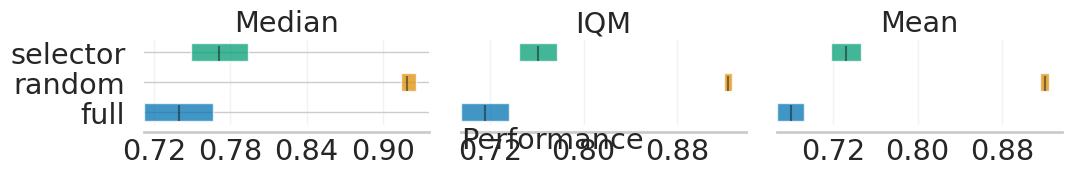

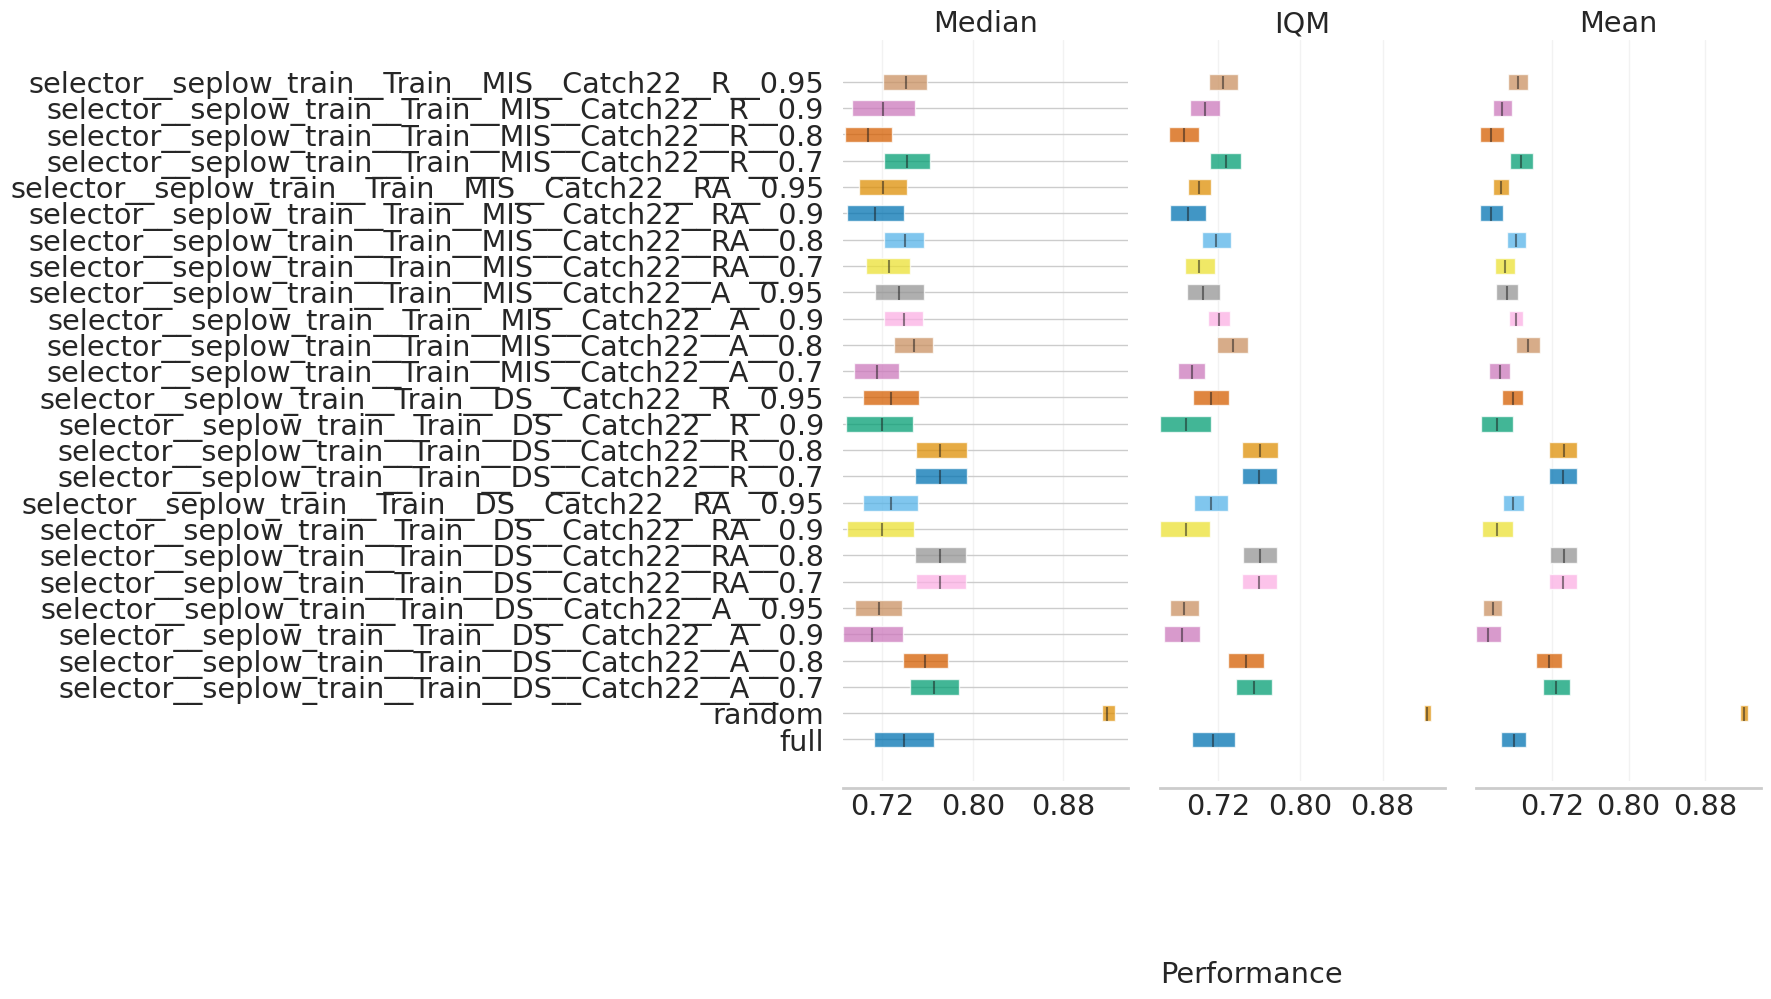

In [38]:

algos = [a for a in algorithms if a in ["full", "oracle", "random", best_selector]]
aggregate_scores["selector"] = aggregate_scores[best_selector]
aggregate_score_cis["selector"] = aggregate_score_cis[best_selector]
algos = [a for a in algos if a in ["full", "oracle", "random"]] + ["selector"]

fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=metric_names,
  algorithms=algos, xlabel='Performance')
fig.savefig(f"plot_{benchmark_id}.pdf", dpi=300, bbox_inches="tight")

fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=metric_names,
  algorithms=algorithms, xlabel='Performance')
fig.savefig(f"plot_{benchmark_id}_all.pdf", dpi=300, bbox_inches="tight")

## Performance Profile

INFO:absl:Calculating estimates for full ...


INFO:absl:Calculating estimates for random ...
INFO:absl:Calculating estimates for selector__seplow_train__Train__DS__Catch22__RA__0.8 ...


<Axes: xlabel='Overall Performance $(\\tau)$', ylabel='Fraction of runs with score $> \\tau$'>

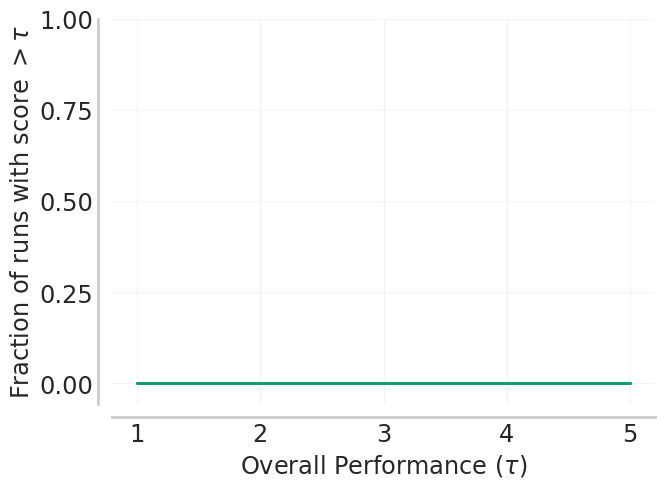

In [39]:
tau_list = np.linspace(1, 5, 21)
perf_dict_tmp = {k: v for k, v in perf_dict.items() if k in ["full", "oracle", "random", best_selector]}
score_distributions, score_distributions_cis = rly.create_performance_profile(
    perf_dict_tmp, tau_list=tau_list)
# Plot score distributions
fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
plot_utils.plot_performance_profiles(
  score_distributions, tau_list=tau_list,
  performance_profile_cis=score_distributions_cis,
  # colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
  xlabel=r'Overall Performance $(\tau)$',
  ax=ax)

# Distance to Oracle

In [28]:
from functools import partial

def l1_dist(a, b) -> float:
    return a - b 

def l2_dist(a, b) -> float:
    return (a - b) ** 2

def calc_dist(x: pd.DataFrame, distance_function) -> pd.DataFrame:
    x = x.reset_index()
    instance_id = x["instance"][0]
    origins = x["origin"]
    groundtruth = "oracle"
    idx_gt = list(origins).index(groundtruth)
    dist = distance_function(x["overall_performance"][idx_gt], x["overall_performance"])
    comparison_names = [f"{groundtruth} - {origin}" for origin in origins]
    ret = pd.DataFrame({
        "instance": instance_id,
        "distance_name": distance_function.__name__,
        "distance": dist,
        "compared": comparison_names
    })
    return ret

distance_functions=[l1_dist, l2_dist]

# Compute distance between oracle performance and performance on full training set
diffs_per_instance = pd.concat([perf.groupby("instance").apply(calc_dist, distance_function=func) for func in distance_functions], axis=0).reset_index(drop=True)
diffs_per_instance

ValueError: 'oracle' is not in list

In [ ]:
# Sort df by agg_fun
agg_fun = np.mean

sorted_series = diffs_per_instance.groupby(["compared"]).apply(lambda x: agg_fun(x["distance"])).sort_values()
sorter = list(sorted_series.index)

df = diffs_per_instance.sort_values(by="compared", key=lambda column: column.map(lambda e: sorter.index(e)))
df = df[df["distance_name"] == "l2_dist"]

fig = plt.figure(figsize=(12,5), dpi=300)
ax = fig.add_subplot(111)
ax = sns.boxplot(data=df, x="compared", y="distance", ax=ax, fliersize=2)
ax.tick_params(axis='x', labelrotation=90, labelsize=5)
# ax.set_ylim(0, ax.get_ylim()[1])
plt.show()

fig = plt.figure(figsize=(12,5), dpi=300)
ax = fig.add_subplot(111)
ax = sns.barplot(data=df, x="compared", y="distance", ax=ax) #, err_kws={"color": ".5", "linewidth": 1},)
ax.tick_params(axis='x', labelrotation=90, labelsize=5)
# ax.set_ylim(0, ax.get_ylim()[1])
plt.show()


In [ ]:
agg_fun = np.mean
diffs = diffs_per_instance.groupby(["compared"]).apply(lambda x: agg_fun(x["distance"]))
diffs = diffs.sort_values()
sns.set_style("whitegrid")
sns.set_palette("colorblind")
fig = plt.figure(figsize=(12,5), dpi=300)
ax = fig.add_subplot(111)
ax = sns.barplot(x=diffs.index, y=diffs.values, ax=ax)
ax.tick_params(axis='x', labelrotation=90, labelsize=5)
plt.show()
